In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import xarray as xr
import numpy as np
import pandas as pd
import calendar
import seaborn as sns
import seaborn_image as isns
import calendar

In [2]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

In [3]:
plt.style.use('seaborn-pastel')
isns.set_context(mode="notebook", fontfamily="Times")
sns.set_context(font_scale=0.8)

In [4]:
mesh_mask = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/masks/mesh_mask.nc')

In [5]:
mask = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/masks/tmaskm.nc')

In [6]:
mask = mask.tmask.isel(time=0)

### Ocean slicing and mixed layer depth average

In [7]:
# calculate volume for each grid cell

dx = mesh_mask.e1t 
dy = mesh_mask.e2t
grid_cell_area = dx * dy # m2

In [8]:
gridded_mesh = grid_cell_area.isel(t=0)

In [9]:
# apply mask to weighted grid cells

ocean_area = gridded_mesh * mask

In [10]:
ocean_area_sliced = ocean_area.sel(x=slice(520,595),y=slice(330,435),z=0)

In [11]:
# alkalinity weighed only over the z axis (depth)

In [12]:
layer_depth = mask.isel(x=slice(520,595),y=slice(330,435),z=slice(0,6))

In [13]:
layer_depth = layer_depth.sum('z') # m

In [14]:
layer_depth = layer_depth.where(layer_depth)

In [15]:
layer_depth = layer_depth.to_dataset(name='tmask')

In [16]:
layer_depth = layer_depth.to_dataframe()

In [17]:
# condition

max_depth = [
    (layer_depth.tmask == 0),
    (layer_depth.tmask == 1),
    (layer_depth.tmask == 2),
    (layer_depth.tmask == 3),
    (layer_depth.tmask == 4),
    (layer_depth.tmask == 5),
    (layer_depth.tmask == 6),
]

values_depth = [3.04, 9.45, 16.36, 23.89, 32.20, 41.48, 51.94]

layer_depth['tmask'] = np.select(max_depth, values_depth)

In [18]:
layer_depth = layer_depth.to_xarray()

In [19]:
layer_depth = layer_depth.where(layer_depth)

In [20]:
ocean_area_sliced_dp = ocean_area_sliced.isel(x=slice(58,60),y=slice(41,43))

### Alkalinity weighted only over the z axis (depth)

In [54]:
alk_weighted_baseline = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_baseline_2.6_cropped.nc',
                                         decode_times=True).isel(deptht=slice(0,6))

In [ ]:
alk_weighted_baseline = (alk_weighted_baseline.ALK * 1.025).to_dataset(name='ALK') # mmol/m3

In [ ]:
# iterate over all layers and append

alk_base_layers = []

for x in (range(len(alk_weighted_baseline.deptht))):
    if x == 0:
        alk_n_base = alk_weighted_baseline.ALK.isel(deptht=x) * alk_weighted_baseline.deptht[x] 
        alk_base_layers.append(alk_n_base)
    else:
        alk_n_base = alk_weighted_baseline.ALK.isel(deptht=x) * (alk_weighted_baseline.deptht[x] - alk_weighted_baseline.deptht[x-1])
        alk_base_layers.append(alk_n_base)

In [ ]:
weighted_base_alk = sum(alk_base_layers) / layer_depth.tmask # mmol/m3 * m / m

In [ ]:
weighted_base_alk = weighted_base_alk.to_dataset(name='ALK')

In [ ]:
alk_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_OAE_2.6_cropped.nc',
                                    decode_times=True).isel(deptht=slice(0, 6))

In [ ]:
alk_weighted_oae = (alk_weighted_oae.ALK * 1.025).to_dataset(name='ALK') # mmol/m3

In [ ]:
# iterate over all layers and append

alk_oae_layers = []

for x in list((range(len(alk_weighted_oae.deptht)))):
    if x == 0:
        alk_n_oae = alk_weighted_oae.ALK.isel(deptht=x) * alk_weighted_oae.deptht[x] 
        alk_oae_layers.append(alk_n_oae)
    else:
        alk_n_oae = alk_weighted_oae.ALK.isel(deptht=x) * (alk_weighted_oae.deptht[x] - alk_weighted_oae.deptht[x-1])
        alk_oae_layers.append(alk_n_oae)

In [ ]:
weighted_oae_alk = sum(alk_oae_layers) / layer_depth.tmask # mmol/m3 * m / m

In [ ]:
weighted_oae_alk = weighted_oae_alk.to_dataset(name='ALK')

In [ ]:
# weighted_base_alk.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_amplitude_base.nc')
# weighted_oae_alk.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_amplitude_oae.nc')

### DIC weighted only over the z axis (depth)

In [20]:
dic_weighted_baseline = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_Baseline_2.6_cropped.nc', 
                                        decode_times=True).isel(deptht=slice(0, 6), z=0)

In [21]:
dic_weighted_base = (dic_weighted_baseline.DIC * 1.025).to_dataset(name='DIC') # mmol/m3

In [ ]:
# iterate over all layers and append

dic_base_layers = []

for x in list((range(len(dic_weighted_base.deptht)))):
    if x == 0:
        dic_n_base = dic_weighted_base.DIC.isel(deptht=x) * dic_weighted_base.deptht[x] 
        dic_base_layers.append(dic_n_base)
    else:
        dic_n_base = dic_weighted_base.DIC.isel(deptht=x) * (dic_weighted_base.deptht[x] - dic_weighted_base.deptht[x-1])
        dic_base_layers.append(dic_n_base)

In [ ]:
dic_weighted_base = sum(dic_base_layers) / layer_depth.tmask

In [ ]:
dic_weighted_base = dic_weighted_base.to_dataset(name='DIC')

In [63]:
dic_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_OAE_2.6_cropped.nc', 
                                    decode_times=True).isel(deptht=slice(0, 6), z=0)

In [ ]:
dic_weighted_oae = (dic_weighted_oae.DIC * 1.025).to_dataset(name='DIC') # mmol/m3

In [ ]:
# iterate over all layers and append

dic_oae_layers = []

for x in list((range(len(dic_weighted_oae.deptht)))):
    if x == 0:
        dic_n_oae = dic_weighted_oae.DIC.isel(deptht=x) * dic_weighted_oae.deptht[x] 
        dic_oae_layers.append(dic_n_oae)
    else:
        dic_n_oae = dic_weighted_oae.DIC.isel(deptht=x) * (dic_weighted_oae.deptht[x] - dic_weighted_oae.deptht[x-1])
        dic_oae_layers.append(dic_n_oae)

In [ ]:
dic_weighted_oae = sum(dic_oae_layers) / layer_depth.tmask # mmol/m3 * m / m

In [ ]:
dic_weighted_oae = dic_weighted_oae.to_dataset(name='DIC')

In [ ]:
#dic_weighted_base.to_netcdf('/Users/chiaraciscato/Desktop/geomar/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_amplitude_base.nc')
#dic_weighted_oae.to_netcdf('/Users/chiaraciscato/Desktop/geomar/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_amplitude_oae.nc')

### DIC as a function of depth

In [72]:
# calculate volume for each grid cell

dx = mesh_mask.e1t 
dy = mesh_mask.e2t

grid_cell_area = dx * dy  # m2

In [73]:
gridded_mesh = grid_cell_area.isel(t=0)

In [74]:
# apply mask to weighted grid cells

ocean_area = gridded_mesh * mask

In [75]:
ocean_area_sliced = ocean_area.sel(x=slice(520,595),y=slice(330,435),z=slice(0,6))

In [76]:
dic_col_base = (dic_weighted_baseline.DIC * 1.025).to_dataset(name='DIC') # mmol/m3

In [77]:
dic_col_base = dic_col_base.where(dic_col_base)

In [78]:
dic_col_base = dic_col_base.sel(time_counter=slice('2090', '2100'))

In [79]:
dic_col_base = ocean_area_sliced * dic_col_base.DIC # mmol/m3 * m2

In [80]:
dic_col_base = dic_col_base.where(dic_col_base)

In [81]:
dic_col_layers_base = []

for x in list((range(len(dic_col_base.deptht)))):
    dic_n_base = (dic_col_base.isel(deptht=x).sum(['x', 'y']) / ocean_area_sliced.isel(z=x).sum(['x', 'y'])).mean()
    dic_col_layers_base.append(dic_n_base)

In [82]:
dicList_base = []
depthtList_base = []
for x in dic_col_layers_base:
    dic_base=x.to_dataset(name='DIC').DIC.values
    deptht_base=x.to_dataset(name='DIC').deptht.values
    dicList_base.append(dic_base)
    depthtList_base.append(deptht_base)

dic_layers_base = pd.DataFrame({'DIC':dicList_base, 'depth':depthtList_base})

In [84]:
dic_col_oae = (dic_weighted_oae.DIC * 1.025).to_dataset(name='DIC') # mmol/m3

In [85]:
dic_col_oae = dic_col_oae.where(dic_col_oae)

In [86]:
dic_col_oae = dic_col_oae.sel(time_counter=slice('2090', '2100'))

In [87]:
dic_col_oae = ocean_area_sliced * dic_col_oae.DIC # mmol/m3 * m2

In [88]:
dic_col_oae = dic_col_oae.where(dic_col_oae)

In [89]:
dic_col_layers_oae = []

for x in list((range(len(dic_col_oae.deptht)))):
    dic_n_oae = (dic_col_oae.isel(deptht=x).sum(['x', 'y']) / ocean_area_sliced.isel(z=x).sum(['x', 'y'])).mean()
    dic_col_layers_oae.append(dic_n_oae)

In [90]:
dicList_oae = []
depthtList_oae = []
for x in dic_col_layers_oae:
    dic_oae=x.to_dataset(name='DIC').DIC.values
    deptht_oae=x.to_dataset(name='DIC').deptht.values
    dicList_oae.append(dic_oae)
    depthtList_oae.append(deptht_oae)

dic_layers_oae = pd.DataFrame({'DIC':dicList_oae, 'depth':depthtList_oae})

In [32]:
dic_layers_base = dic_layers_base.to_xarray()
dic_layers_oae = dic_layers_oae.to_xarray()

### Alkalinity weighted over x,y,z

In [ ]:
sliced_alk_baseline = ocean_area_sliced * weighted_base_alk.ALK # baseline

In [ ]:
regridded_alk_base = sliced_alk_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [ ]:
regridded_alk_base = regridded_alk_base.to_dataset(name='ALK')

In [ ]:
sliced_alk_oae = ocean_area_sliced * alk_weighted_oae.ALK # oae

In [ ]:
regridded_alk_oae = sliced_alk_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [ ]:
regridded_alk_oae = regridded_alk_oae.to_dataset(name='ALK')

In [ ]:
#regridded_alk_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_baseline_2.6_weighted.nc')
#regridded_alk_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_oae_2.6_weighted.nc')

### Alkalinity surface weighted over x and y

In [ ]:
alk_surface_baseline = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_baseline_2.6_cropped.nc',
                                         decode_times=True).isel(deptht=slice(0,1))

In [ ]:
alk_surface_baseline = (alk_surface_baseline.ALK * 1.025).to_dataset(name='ALK') # mmol/m3

In [ ]:
alk_surface_baseline = alk_surface_baseline.where(alk_surface_baseline)

In [ ]:
alk_surface_baseline = ocean_area_sliced * alk_surface_baseline.ALK # mmol/m3 * m2

In [ ]:
regridded_alk_surf_base = alk_surface_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y']) # mmol/m3 * m2 / m2

In [ ]:
regridded_alk_surf_base = regridded_alk_surf_base.where(regridded_alk_surf_base)

In [ ]:
regridded_alk_surf_base = regridded_alk_surf_base.to_dataset(name='ALK')

In [ ]:
alk_surface_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_OAE_2.6_cropped.nc',
                                         decode_times=True).isel(deptht=slice(0,1))

In [ ]:
alk_surface_oae = (alk_surface_oae.ALK * 1.025).to_dataset(name='ALK') # mmol/m3

In [ ]:
alk_surface_oae = alk_surface_oae.where(alk_surface_oae)

In [ ]:
alk_surface_oae = ocean_area_sliced * alk_surface_oae.ALK # mmol/m3 * m2

In [ ]:
regridded_alk_surf_oae = alk_surface_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y']) # mmol/m3 * m2 / m2

In [ ]:
regridded_alk_surf_oae = regridded_alk_surf_oae.where(regridded_alk_surf_oae)

In [ ]:
regridded_alk_surf_oae = regridded_alk_surf_oae.to_dataset(name='ALK')

In [ ]:
regridded_alk_surf_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_baseline_surf_2.6_try.nc')
regridded_alk_surf_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_oae_surf_2.6_TRY.nc')

### Alkalinity weighted over x and y for the first 150 metres:

In [6]:
# calculate volume for each grid cell

dx = mesh_mask.e1t 
dy = mesh_mask.e2t

grid_cell_area = dx * dy  # m2

In [7]:
gridded_mesh = grid_cell_area.isel(t=0)

In [8]:
# apply mask to weighted grid cells

ocean_area = gridded_mesh * mask

In [9]:
ocean_area_sliced = ocean_area.sel(x=slice(520,595),y=slice(330,435),z=slice(0,12))

In [10]:
alk_col_baseline = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_baseline_2.6_cropped.nc', decode_times=True)

In [11]:
alk_col_baseline = (alk_col_baseline.ALK * 1.025).to_dataset(name='ALK') # mmol/m3

In [12]:
alk_col_baseline = alk_col_baseline.where(alk_col_baseline)

In [13]:
alk_col_baseline = alk_col_baseline.sel(time_counter=slice('2090', '2100'))

In [14]:
alk_col_baseline = ocean_area_sliced * alk_col_baseline.ALK # mmol/m3 * m2

In [15]:
alk_col_baseline = alk_col_baseline.where(alk_col_baseline)

In [16]:
alk_col_baseline = alk_col_baseline.isel(z=0)

In [17]:
alk_col_layers = []

for x in list((range(len(alk_col_baseline.deptht)))):
    alk_n_base = (alk_col_baseline.isel(deptht=x).sum(['x', 'y']) / ocean_area_sliced.isel(z=x).sum(['x', 'y'])).mean()
    alk_col_layers.append(alk_n_base)

In [18]:
alkList = []
depthtList = []
for x in alk_col_layers:
    alk=x.to_dataset(name='ALK').ALK.values
    deptht=x.to_dataset(name='ALK').deptht.values
    alkList.append(alk)
    depthtList.append(deptht)

alk_layers_base = pd.DataFrame({'ALK':alkList, 'depth':depthtList})

In [19]:
alk_col_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_OAE_2.6_cropped.nc', decode_times=True)

In [20]:
alk_col_oae = (alk_col_oae.ALK * 1.025).to_dataset(name='ALK') # mmol/m3

In [21]:
alk_col_oae = alk_col_oae.where(alk_col_oae)

In [22]:
alk_col_oae = alk_col_oae.sel(time_counter=slice('2090', '2100'))

In [23]:
alk_col_oae = ocean_area_sliced * alk_col_oae.ALK # mmol/m3 * m2

In [24]:
alk_col_oae = alk_col_oae.where(alk_col_oae)

In [25]:
alk_col_oae = alk_col_oae.isel(z=0)

In [26]:
alk_col_layers_oae = []

for x in list((range(len(alk_col_oae.deptht)))):
    alk_n_oae = (alk_col_oae.isel(deptht=x).sum(['x', 'y']) / ocean_area_sliced.isel(z=x).sum(['x', 'y'])).mean()
    alk_col_layers_oae.append(alk_n_oae)

In [27]:
alkList_oae = []
depthtList_oae = []
for x in alk_col_layers_oae:
    alk_oae=x.to_dataset(name='ALK').ALK.values
    deptht_oae=x.to_dataset(name='ALK').deptht.values
    alkList_oae.append(alk_oae)
    depthtList_oae.append(deptht_oae)

alk_layers_oae = pd.DataFrame({'ALK':alkList_oae, 'depth':depthtList_oae})

In [32]:
alk_layers_base = alk_layers_base.to_xarray()
alk_layers_oae = alk_layers_oae.to_xarray()

In [34]:
alk_layers_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_baseline_col_2.6_weighted.nc')
alk_layers_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_oae_col_2.6_weighted.nc')

### DIC weighted over x,y,z

In [ ]:
sliced_dic_baseline = ocean_area_sliced * dic_weighted_base.DIC # mmol/m3 * m2

In [ ]:
regridded_dic_base = sliced_dic_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y']) # mmol/m3 * m2 / m2

In [ ]:
regridded_dic_base = regridded_dic_base.to_dataset(name='DIC')

In [ ]:
sliced_dic_oae = ocean_area_sliced * dic_weighted_oae.DIC # oae

In [ ]:
regridded_dic_oae = sliced_alk_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [ ]:
regridded_dic_oae = regridded_dic_oae.to_dataset(name='DIC')

In [ ]:
#regridded_dic_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_baseline_2.6_weighted.nc')
#regridded_dic_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_oae_2.6_weighted.nc')

### Weighted alkalinity at location point

In [84]:
alk_weighted_baseline_dp = weighted_base_alk.isel(x=slice(58,60),y=slice(41,43))

In [85]:
sliced_alk_baseline_dp = ocean_area_sliced_dp * alk_weighted_baseline_dp.ALK

In [86]:
regridded_alk_base_dp = sliced_alk_baseline_dp.sum(['x', 'y']) / ocean_area_sliced_dp.sum(['x', 'y'])

In [87]:
regridded_alk_base_dp = regridded_alk_base_dp.to_dataset(name='ALK')

In [88]:
alk_weighted_oae_dp = alk_weighted_oae.isel(x=slice(58,60),y=slice(41,43)) 

In [89]:
sliced_alk_oae_dp = ocean_area_sliced_dp * alk_weighted_oae_dp.ALK

In [90]:
regridded_alk_oae_dp = sliced_alk_oae_dp.sum(['x', 'y']) / ocean_area_sliced_dp.sum(['x', 'y'])

In [91]:
regridded_alk_oae_dp = regridded_alk_oae_dp.to_dataset(name='ALK')

In [92]:
#regridded_alk_base_dp.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_baseline_2.6_weighted_dp.nc')
#regridded_alk_oae_dp.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/Alkalinity/ALK_oae_2.6_weighted_dp.nc')

### Weighted DIC at location point

In [93]:
dic_weighted_baseline_dp = dic_weighted_base.isel(x=slice(58,60),y=slice(41,43))

In [94]:
sliced_dic_baseline_dp = ocean_area_sliced_dp * dic_weighted_baseline_dp.DIC

In [95]:
regridded_dic_base_dp = sliced_dic_baseline_dp.sum(['x', 'y']) / ocean_area_sliced_dp.sum(['x', 'y'])

In [96]:
regridded_dic_base_dp = regridded_dic_base_dp.to_dataset(name='DIC')

In [97]:
dic_weighted_oae_dp = dic_weighted_oae.isel(x=slice(58,60),y=slice(41,43)) 

In [98]:
sliced_dic_oae_dp = ocean_area_sliced_dp * dic_weighted_oae_dp.DIC

In [99]:
regridded_dic_oae_dp = sliced_dic_oae_dp.sum(['x', 'y']) / ocean_area_sliced_dp.sum(['x', 'y'])

In [100]:
regridded_dic_oae_dp = regridded_dic_oae_dp.to_dataset(name='DIC')

In [101]:
#regridded_dic_base_dp.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_baseline_2.6_weighted_dp.nc')
#regridded_dic_oae_dp.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/DIC/DIC_oae_2.6_weighted_dp.nc')

### Weighted CO2 flux

In [21]:
co2flux_weighted_base = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_Baseline_2.6_cropped.nc')

In [22]:
sliced_co2flux_baseline = ocean_area_sliced * co2flux_weighted_base.co2flux # baseline

In [23]:
regridded_co2flux_base = sliced_co2flux_baseline.sum(['x', 'y'])  / ocean_area_sliced.sum(['x', 'y']) 

In [24]:
regridded_co2flux_base = regridded_co2flux_base.to_dataset(name='co2flux')

In [25]:
co2flux_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/CO2flux_OAE_2.6_cropped.nc')

In [26]:
sliced_co2flux_oae = ocean_area_sliced * co2flux_weighted_oae.co2flux # oae

In [27]:
regridded_co2flux_oae = sliced_co2flux_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [28]:
regridded_co2flux_oae = regridded_co2flux_oae.to_dataset(name='co2flux')

In [29]:
#regridded_co2flux_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_baseline_2.6_weighted.nc')
#regridded_co2flux_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_oae_2.6_weighted.nc')

In [30]:
base = (co2flux_weighted_base * 31536000 / 3.6667 * ocean_area_sliced)

In [31]:
oae = (co2flux_weighted_oae * 31536000 / 3.6667 * ocean_area_sliced)

In [32]:
diff = ((oae - base) * 1e-12)

In [33]:
diff = diff.isel(time=0).sel(time_counter=slice('2090', '2100'))

In [34]:
month_length = diff.time_counter.dt.days_in_month
diff_avg = ((diff * month_length).resample(time_counter='M').sum() / month_length.resample(time_counter='M').sum())

In [35]:
diff_avg = diff_avg.where(diff_avg)

In [36]:
diff_avg = -(diff_avg.co2flux.mean(dim='time_counter')).to_dataset(name='co2flux')

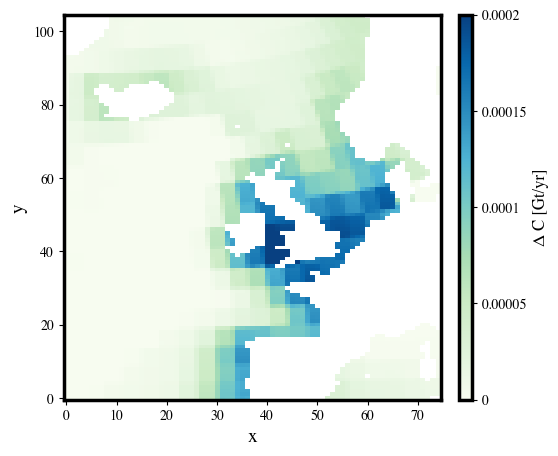

In [37]:
plt.figure(figsize=(6, 5))

im = diff_avg.co2flux.plot.pcolormesh(
    add_colorbar=False, vmin = 0, vmax = 0.0002, cmap='GnBu'
)

cbar = plt.colorbar(im, aspect = 30, pad=0.04, ticks=[0, 0.00005, 0.0001, 0.00015, 0.0002])
cbar.set_label('Δ C [Gt/yr]', fontsize=12)
cbar.ax.set_yticklabels(['0', '0.00005', '0.0001', '0.00015', '0.0002'])

plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title("")

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(10)
        
plt.savefig('/Users/chiaraciscato/Desktop/geomar/geomarcode/SSP1_2.6/CO2flux/figs/co2fluxchg26.png')

In [43]:
diff_avg.sum(['x','y'])

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     float64 0.0
Data variables:
    co2flux  float64 0.1779

In [38]:
# diff_avg.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/CO2flux/co2flux_uptakechng_26.nc')

### Weighted fCO2

In [111]:
fco2_weighted_base = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/FCO2/fco2_baseline_2.6_cropped.nc')

In [112]:
sliced_fco2_baseline = ocean_area_sliced * fco2_weighted_base.fco2 # baseline

In [113]:
regridded_fco2_base = sliced_fco2_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [114]:
regridded_fco2_base = regridded_fco2_base.to_dataset(name='fco2')

In [115]:
fco2_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/FCO2/fco2_OAE_2.6_cropped.nc')

In [116]:
sliced_fco2_oae = ocean_area_sliced * fco2_weighted_oae.fco2 # oae

In [117]:
regridded_fco2_oae = sliced_fco2_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [118]:
regridded_fco2_oae = regridded_fco2_oae.to_dataset(name='fco2')

In [119]:
#regridded_fco2_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/FCO2/fco2_baseline_2.6_weighted.nc')
#regridded_fco2_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/FCO2/fco2_oae_2.6_weighted.nc')

### Weighted pH

In [120]:
ph_weighted_base = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_baseline_2.6_cropped.nc')

In [121]:
sliced_ph_baseline = ocean_area_sliced * ph_weighted_base.ph # baseline

In [122]:
regridded_ph_base = sliced_ph_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [123]:
regridded_ph_base = regridded_ph_base.to_dataset(name='ph')

In [124]:
ph_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_OAE_2.6_cropped.nc')

In [125]:
sliced_ph_oae = ocean_area_sliced * ph_weighted_oae.ph # oae

In [126]:
regridded_ph_oae = sliced_ph_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [127]:
regridded_ph_oae = regridded_ph_oae.to_dataset(name='ph')

In [128]:
#regridded_ph_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_baseline_2.6_weighted.nc')
#regridded_ph_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/pH/ph_oae_2.6_weighted.nc')

### Weighted SST

In [21]:
sst_weighted_base = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/SST_2.6/sst_baseline_2.6_cropped.nc')

In [22]:
sliced_sst_baseline = ocean_area_sliced * sst_weighted_base.sst # baseline

In [23]:
regridded_sst_base = sliced_sst_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [24]:
regridded_sst_base = regridded_sst_base.to_dataset(name='sst')

In [25]:
sst_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/SST_2.6/sst_OAE_2.6_cropped.nc')

In [26]:
sliced_sst_oae = ocean_area_sliced * sst_weighted_oae.sst # oae

In [27]:
regridded_sst_oae = sliced_sst_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [28]:
regridded_sst_oae = regridded_sst_oae.to_dataset(name='sst')

In [29]:
regridded_sst_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/SST_2.6/sst_baseline_2.6_weighted.nc')
regridded_sst_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/SST_2.6/sst_oae_2.6_weighted.nc')

### Weighted Mixed Layer Depth 

In [ ]:
mld_weighted_base = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SWT&MLD/MLD_2.6/MLD_baseline_2.6_cropped.nc')

In [ ]:
sliced_mld_baseline = ocean_area_sliced * mld_weighted_base.mld # baseline

In [ ]:
regridded_mld_base = sliced_mld_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [ ]:
regridded_mld_base = regridded_mld_base.to_dataset(name='mld')

In [ ]:
mld_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/SWT&MLD/MLD_2.6/MLD_OAE_2.6_cropped.nc')

In [ ]:
sliced_mld_oae = ocean_area_sliced * mld_weighted_oae.mld # oae

In [ ]:
regridded_mld_oae = sliced_mld_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [ ]:
regridded_mld_oae = regridded_mld_oae.to_dataset(name='mld')

In [ ]:
#regridded_mld_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/mld_baseline_2.6_weighted.nc')
#regridded_mld_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/SSP1_2.6/mld_oae_2.6_weighted.nc')

### Weighted Wind Speed

In [22]:
wind_weighted_base = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/wind speed/wind_baseline_2.6_cropped.nc')

In [23]:
sliced_wind_baseline = ocean_area_sliced * wind_weighted_base.wind # baseline

In [24]:
regridded_wind_base = sliced_wind_baseline.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [25]:
regridded_wind_base = regridded_wind_base.to_dataset(name='wind')

In [26]:
wind_weighted_oae = xr.open_dataset('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/wind speed/wind_oae_2.6_cropped.nc')

In [27]:
sliced_wind_oae = ocean_area_sliced * wind_weighted_oae.wind # oae

In [28]:
regridded_wind_oae = sliced_wind_oae.sum(['x', 'y']) / ocean_area_sliced.sum(['x', 'y'])

In [29]:
regridded_wind_oae = regridded_wind_oae.to_dataset(name='wind')

In [30]:
#regridded_wind_base.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/wind speed/wind_baseline_2.6_weighted.nc')
#regridded_wind_oae.to_netcdf('/Volumes/UnionSine/Cropped_DataTransfer/mld&sst&swt/wind speed/wind_oae_2.6_weighted.nc')